In [263]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [350]:
# read in data
ikea = pd.read_csv('ikea.csv', index_col = 0) # There are some duplicate rows. Get rid of those.


# Since all prices are in Saudi Royals, we can make old_price a numerical column
# also, some values are fractional: ie, 420/2. This means that the unit price for that item is 210.

ikea['divisor'] = 1
ikea['divisor'] = ikea.divisor.where(~ikea.old_price.str.contains('/'),
                                     ikea.old_price.str.split('/').str[1].str.strip(' pack')).astype(float)
ikea['old_price'] = ikea.old_price.str.split('SR ').str[1].str.replace(',','')
ikea['old_unit_price'] = ikea.old_price.where(ikea.old_price.isna(), 
                                               ikea.old_price.str.split('/').str[0].astype(float)/ ikea.divisor)
ikea['unit_price'] = ikea.price.where(ikea.price.isna(), ikea.price/ikea.divisor)

In [351]:
# look at data
ikea.head()

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width,divisor,old_unit_price,unit_price
0,90420332,FREKVENS,Bar furniture,265.0,NaN,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0,1.0,NaN,265.0
1,368814,NORDVIKEN,Bar furniture,995.0,NaN,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0,1.0,NaN,995.0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,NaN,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN,1.0,NaN,2095.0
3,80155205,STIG,Bar furniture,69.0,NaN,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0,1.0,NaN,69.0
4,30180504,NORBERG,Bar furniture,225.0,NaN,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0,1.0,NaN,225.0


### Fast stats
#### Answer the following questions: 
1. How many distinct categories are there? How many distinct items are there per category? 
2. How often are they available online for purchase? 
3. How often do they come in other colors? 
3. How often are each column nans? 
4. Is category correlated with unit price? 

In [352]:
ikea['other_colors_bool'] = 0
ikea['other_colors_bool'] = ikea['other_colors_bool'].where(ikea['other_colors'] == 'No', 1)

ikea['sellable_online'] = ikea['sellable_online'].astype(int)

print(f'There are {ikea.category.nunique()} categories.')
ikea.groupby('category').agg(
    {'item_id': 'count', 'other_colors_bool': ['sum', 'mean'], 'sellable_online': ['sum', 'mean']}
)

There are 17 categories.


item_id other_colors_bool            \
                                       count               sum      mean   
category                                                                   
Bar furniture                             47                 5  0.106383   
Beds                                     208                93  0.447115   
Bookcases & shelving units               548               229  0.417883   
Cabinets & cupboards                     292               187  0.640411   
Café furniture                            26                 5  0.192308   
Chairs                                   481                99  0.205821   
Chests of drawers & drawer units         125                56  0.448000   
Children's furniture                     124                35  0.282258   
Nursery furniture                         97                23  0.237113   
Outdoor furniture                        216                76  0.351852   
Room dividers                             13                 8  0.615385   
Sideboards, buffets & console tables      23                16  0.695652   
Sofas & armchairs                        428               342  0.799065   
TV & media furniture                     190               109  0.573684   
Tables & desks                           612               184  0.300654   
Trolleys                                  28                 2  0.071429   
Wardrobes                                236                43  0.182203   

                                     sellable_online            
                                                 sum      mean  
category                                                        
Bar furniture                                     44  0.936170  
Beds                                             205  0.985577  
Bookcases & shelving units                       547  0.998175  
Cabinets & cupboards                             291  0.996575  
Café furniture                                    26  1.000000  
Chairs                                           477  0.991684  
Chests of drawers & drawer units                 125  1.000000  
Children's furniture                             119  0.959677  
Nursery furniture                                 93  0.958763  
Outdoor furniture                                216  1.000000  
Room dividers                                     13  1.000000  
Sideboards, buffets & console tables              23  1.000000  
Sofas & armchairs                                427  0.997664  
TV & media furniture                             189  0.994737  
Tables & desks                                   608  0.993464  
Trolleys                                          27  0.964286  
Wardrobes                                        236  1.000000

In [363]:
# Proportion of each column that is NaNs
print('Proportion of each column that is NaNs')
for col in ikea.columns :
    print(f'{col}: {np.round(ikea[col].isna().mean(), 2)}')

Proportion of each column that is NaNs
item_id: 0.0
name: 0.0
category: 0.0
price: 0.0
old_price: 0.82
sellable_online: 0.0
link: 0.0
other_colors: 0.0
short_description: 0.0
designer: 0.0
depth: 0.4
height: 0.27
width: 0.16
divisor: 0.0
old_unit_price: 0.82
unit_price: 0.0
other_colors_bool: 0.0


### Physical Dimensions
I think in general, we can expect the physical dimensions of an object ot be correlated strongly with it's cost simply because bigger things take more material and labor to produce. There will be a few exceptions to this though, and most of them will probably have to do with the data being not great. 

Take for example Item 9333523 by Francis Cayouette. This is a bar table with four stools, but it has NaNs for all three dimensions (probably because they weren't listed on the site since it's a composite product). This is an expensive item at $1200, but it will be an outlier because we have a null dimension for it. For this reason, we remove any product with two or more null values for the physical dimensions. 

For the items that remane, we will fill in the single null value with a 1. This is will help us when we engineer a feature that is the product the of the dimension columns (which we will call item volume). This feature obviously has no basis in reality since the items are not all cubes, but it is a proxy for the size and mass of the object-- however it should be noted that it would be insufficient since we can't assume each product is made of the same material. 

In [426]:
dims = ikea[['category', 'depth', 'height', 'width', 'unit_price']]
dims_complete = dims.loc[~(dims[['depth', 'height', 'width']].isna().sum(axis = 1) > 0)].fillna(1)
dims_complete['physical_volume'] = dims_complete[['depth', 'height', 'width']].prod(axis = 1)
dims_complete.groupby('category')[['physical_volume', 'unit_price']].corr(method = 'spearman')

physical_volume  \
category                                                                
Bar furniture                        physical_volume         1.000000   
                                     unit_price             -0.586688   
Beds                                 physical_volume         1.000000   
                                     unit_price              0.765359   
Bookcases & shelving units           physical_volume         1.000000   
                                     unit_price              0.794644   
Cabinets & cupboards                 physical_volume         1.000000   
                                     unit_price              0.845677   
Café furniture                       physical_volume         1.000000   
                                     unit_price             -0.194653   
Chairs                               physical_volume         1.000000   
                                     unit_price              0.748373   
Chests of drawers & drawer units     physical_volume         1.000000   
                                     unit_price              0.701251   
Children's furniture                 physical_volume         1.000000   
                                     unit_price              0.888511   
Nursery furniture                    physical_volume         1.000000   
                                     unit_price              0.861587   
Outdoor furniture                    physical_volume         1.000000   
                                     unit_price              0.934897   
Room dividers                        physical_volume         1.000000   
                                     unit_price              0.582575   
Sideboards, buffets & console tables physical_volume         1.000000   
                                     unit_price              0.902748   
Sofas & armchairs                    physical_volume         1.000000   
                                     unit_price              0.847165   
TV & media furniture                 physical_volume         1.000000   
                                     unit_price              0.821879   
Tables & desks                       physical_volume         1.000000   
                                     unit_price              0.676942   
Trolleys                             physical_volume         1.000000   
                                     unit_price              0.886158   
Wardrobes                            physical_volume         1.000000   
                                     unit_price              0.821435   

                                                      unit_price  
category                                                          
Bar furniture                        physical_volume   -0.586688  
                                     unit_price         1.000000  
Beds                                 physical_volume    0.765359  
                                     unit_price         1.000000  
Bookcases & shelving units           physical_volume    0.794644  
                                     unit_price         1.000000  
Cabinets & cupboards                 physical_volume    0.845677  
                                     unit_price         1.000000  
Café furniture                       physical_volume   -0.194653  
                                     unit_price         1.000000  
Chairs                               physical_volume    0.748373  
                                     unit_price         1.000000  
Chests of drawers & drawer units     physical_volume    0.701251  
                                     unit_price         1.000000  
Children's furniture                 physical_volume    0.888511  
                                     unit_price         1.000000  
Nursery furniture                    physical_volume    0.861587  
                                     unit_price         1.000000  
Outdoor furniture                    physical_volume    0.934897  
                  

In [427]:
dims_complete.loc[dims_complete.category == 'Bar furniture']

,category,depth,height,width,unit_price,physical_volume
3,Bar furniture,50.0,100.0,60.0,69.0,300000.0
4,Bar furniture,60.0,43.0,74.0,225.0,190920.0
5,Bar furniture,45.0,91.0,40.0,345.0,163800.0
6,Bar furniture,44.0,95.0,50.0,129.0,209000.0
6,Bar furniture,44.0,95.0,50.0,129.0,209000.0
8,Bar furniture,44.0,95.0,50.0,129.0,209000.0
8,Bar furniture,44.0,95.0,50.0,129.0,209000.0
10,Bar furniture,44.0,103.0,52.0,149.0,235664.0
10,Bar furniture,44.0,103.0,52.0,149.0,235664.0
11,Bar furniture,45.0,102.0,40.0,395.0,183600.0


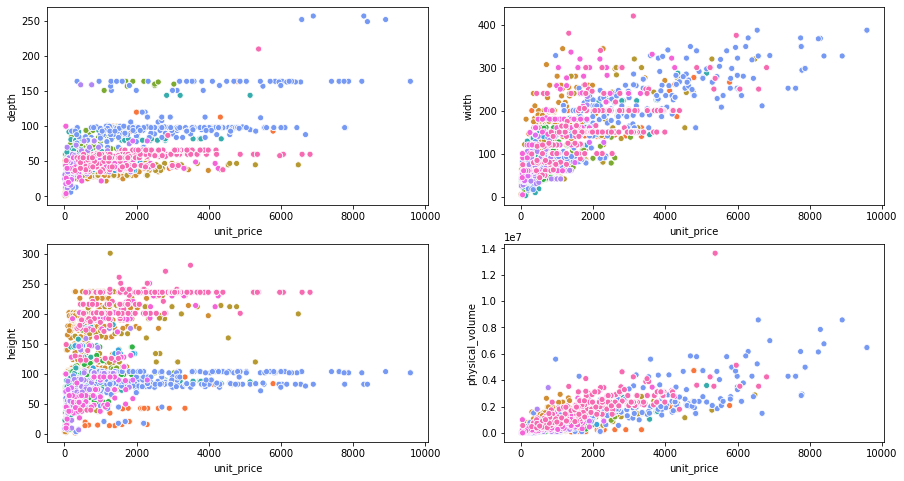

In [428]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 8))


sns.scatterplot(data = dims_complete, x = 'unit_price', y = 'depth', hue = 'category',  ax = axs[0,0], legend = False)
sns.scatterplot(data = dims_complete, x = 'unit_price', y = 'width', hue = 'category',  ax = axs[0,1], legend = False)
sns.scatterplot(data = dims_complete, x = 'unit_price', y = 'height', hue = 'category',  ax = axs[1,0], legend = False)
sns.scatterplot(data = dims_complete, x = 'unit_price', y = 'physical_volume', hue = 'category', ax = axs[1,1], legend = False)

### Cost

In [353]:
# There are duplicate rows because an item can be in multiple categories.
ikea_melt = ikea.melt(id_vars = ['item_id', 'category'],
                      value_vars =['old_unit_price', 'unit_price'], 
                      value_name = 'cost'
                     ).sort_values(['item_id', 'category', 'variable'])

ikea_melt['order'] = 1
ikea_melt['order'] = ikea_melt['order'].where(ikea_melt.variable == 'old_unit_price', 2)
ikea_melt.head()

,item_id,category,variable,cost,order
3251,58487,Trolleys,old_unit_price,895,1
6945,58487,Trolleys,unit_price,537,2
1834,91415,Children's furniture,old_unit_price,NaN,1
5528,91415,Children's furniture,unit_price,5,2
1918,91415,Nursery furniture,old_unit_price,NaN,1


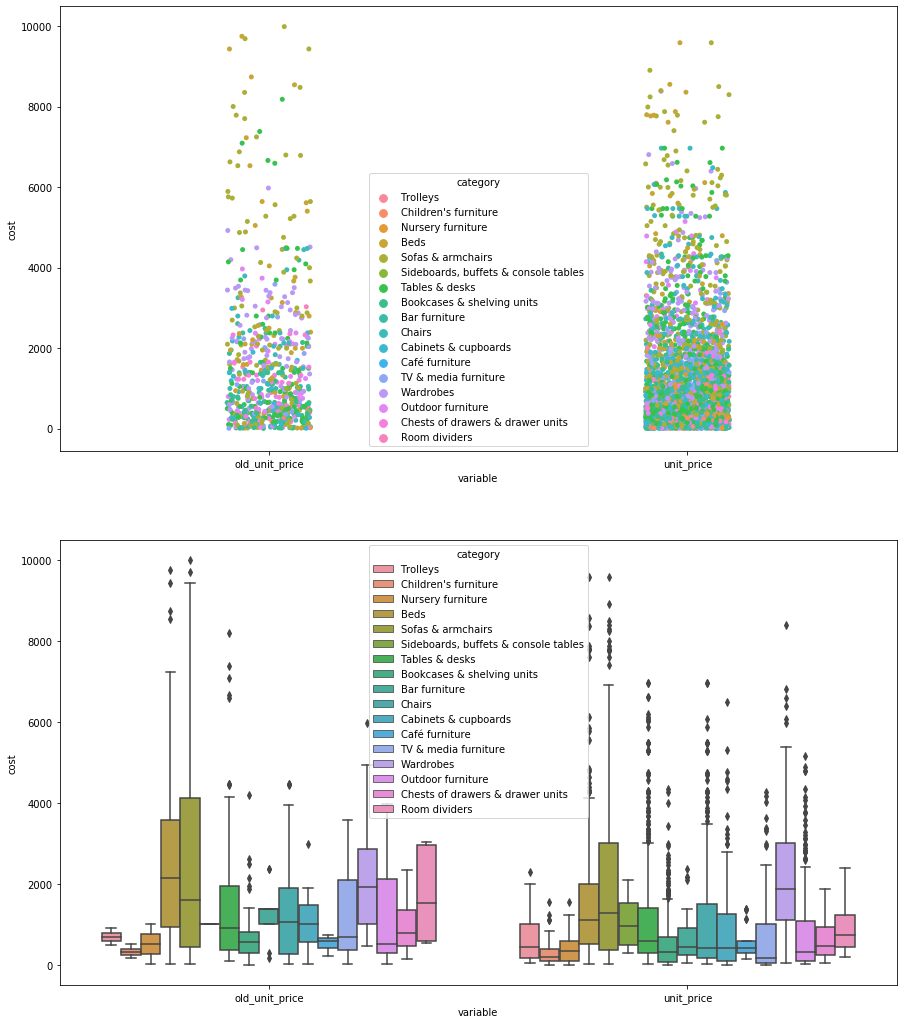

In [354]:
fig, ax = plt.subplots(nrows=2, figsize = (15, 18))
sns.stripplot(data = ikea_melt, y = 'cost', x = 'variable', hue = 'category', ax = ax[0])
sns.boxplot(data = ikea_melt, y = 'cost', x = 'variable', hue = 'category', ax= ax[1])

In [355]:
def log_transform(df):
    if df.cost == np.nan: 
        return np.nan
    else: 
        return np.log(df.cost)
ikea_melt['log_cost'] = ikea_melt.apply(log_transform, axis = 1)

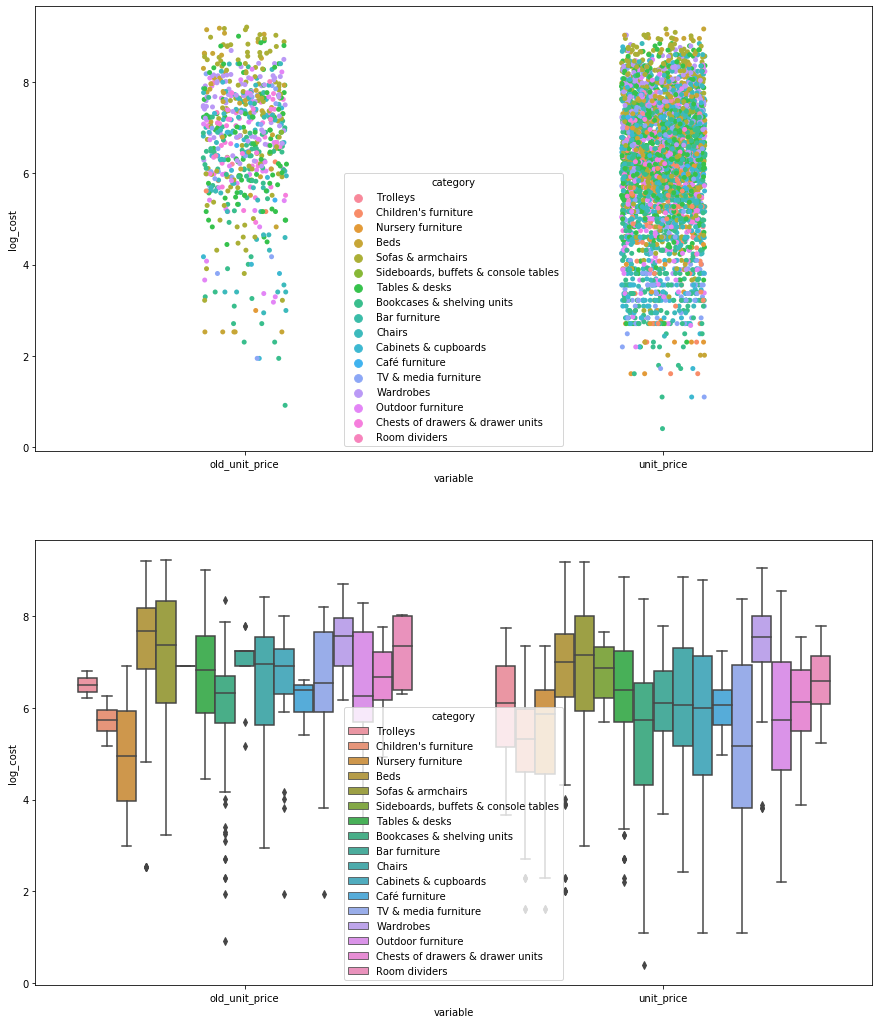

In [356]:
fig, ax = plt.subplots(nrows=2, figsize = (15, 18))

sns.stripplot(data = ikea_melt, y = 'log_cost', x = 'variable', hue = 'category', ax = ax[0])
sns.boxplot(data = ikea_melt, y = 'log_cost', x = 'variable', hue = 'category', ax= ax[1])

plt.show()

In [359]:
# Let's look at percent_change
ikea_melt['pct_diff'] = ikea_melt.groupby(['item_id', 'category']).cost.pct_change() * 100
# I'm curious how many "complete pairs" are in the data
sum(~ikea_melt.pct_diff.isna())

654

In [360]:
ikea_complete_pairs = ikea_melt.merge(ikea_melt.dropna(subset = ['pct_diff']), on = ['item_id', 'category'], how = 'inner', 
                                     suffixes = ['', 'y'])[ikea_melt.columns]

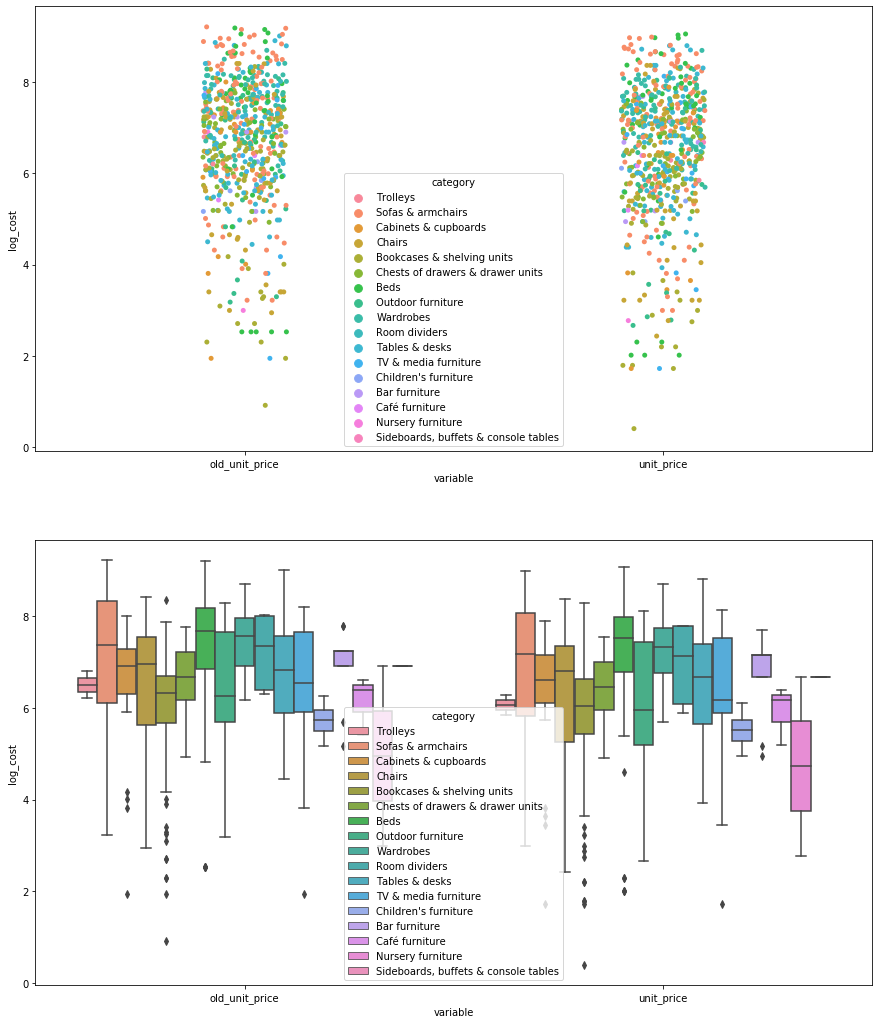

In [358]:
fig, ax = plt.subplots(nrows=2, figsize = (15, 18))

sns.stripplot(data = ikea_complete_pairs, y = 'log_cost', x = 'variable', hue = 'category', ax = ax[0])
sns.boxplot(data = ikea_complete_pairs, y = 'log_cost', x = 'variable', hue = 'category', ax= ax[1])

plt.show()

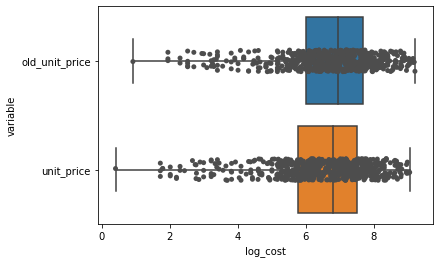

In [418]:

ax = sns.boxplot(x="log_cost", y="variable", data=ikea_complete_pairs, whis=np.inf, )
ax = sns.stripplot(x="log_cost", y="variable", data=ikea_complete_pairs, color=".3")

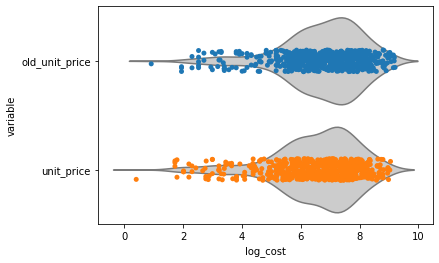

In [421]:
ax = sns.violinplot(x="log_cost", y="variable", data=ikea_complete_pairs,
                    inner=None, color=".8", legend = None)
ax = sns.stripplot(x="log_cost", y="variable",  data=ikea_complete_pairs)

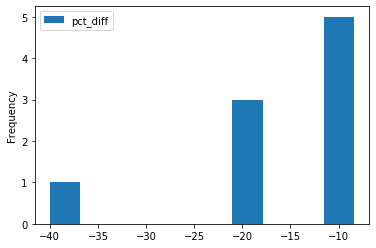

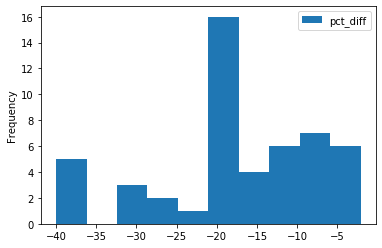

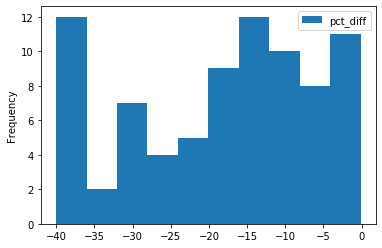

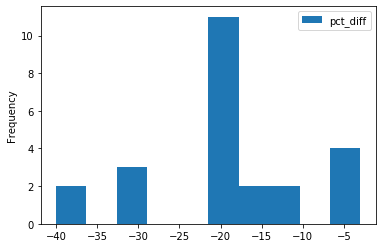

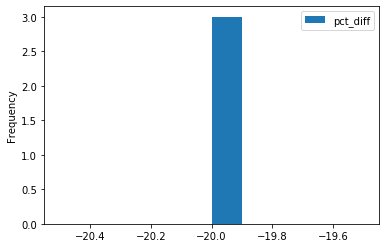

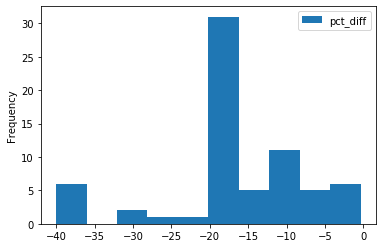

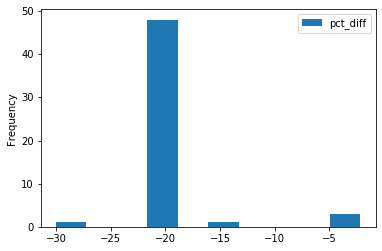

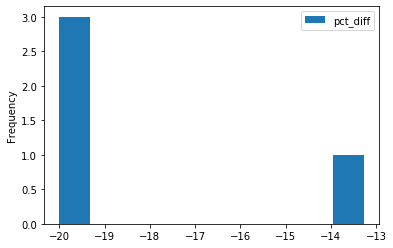

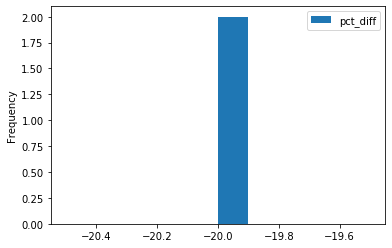

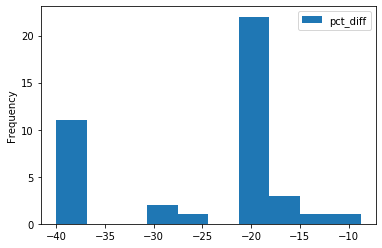

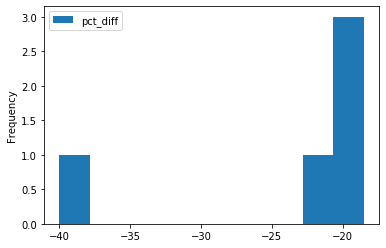

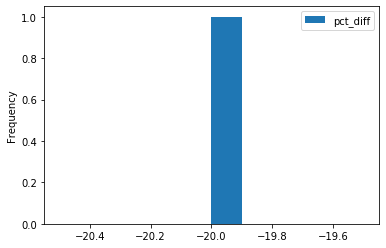

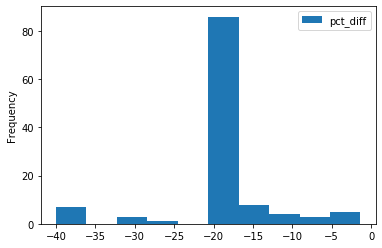

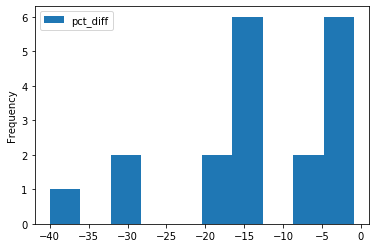

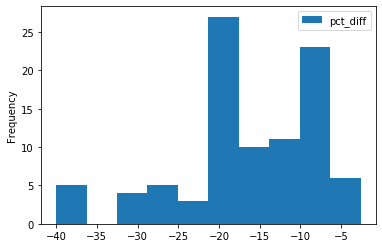

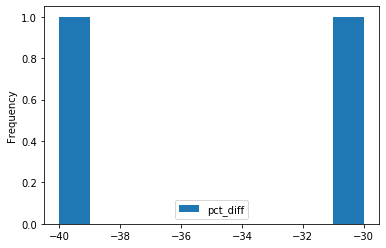

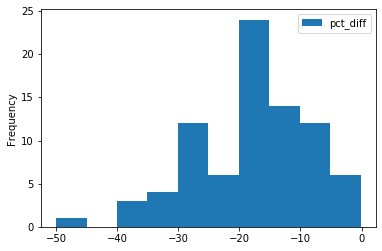

In [328]:
ikea_melt.groupby('category').plot(kind = 'hist' , y = 'pct_diff')
plt.show()

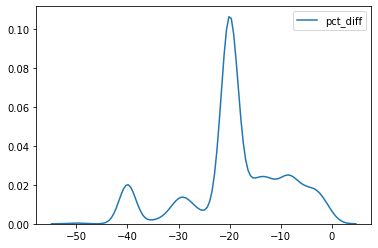

In [336]:
sns.kdeplot(data = ikea_melt.dropna(subset = ['pct_diff']).pct_diff)

In [324]:
# Coming back to cost stuff later
ikea_complete_pairs.groupby('category').agg(
    {'pct_diff': [lambda x: np.round(x.mean(), 2), lambda x: np.round(x.std(), 2), lambda x: (~x.isna()).sum()]}
).reset_index()

category   pct_diff                      
                                         <lambda_0> <lambda_1> <lambda_2>
0                          Bar furniture     -15.84      10.63          9
1                                   Beds     -17.72      10.68         50
2             Bookcases & shelving units     -18.69      12.67         80
3                   Cabinets & cupboards     -19.24       9.93         24
4                         Café furniture     -20.00       0.00          3
5                                 Chairs     -17.09       9.59         68
6       Chests of drawers & drawer units     -19.16       4.41         53
7                   Children's furniture     -18.32       3.37          4
8                      Nursery furniture     -20.00       0.00          2
9                      Outdoor furniture     -25.11       9.59         41
10                         Room dividers     -23.67       9.20          5
11  Sideboards, buffets & console tables     -20.00        NaN          1
12                     Sofas & armchairs     -19.81       6.97        117
13                  TV & media furniture     -13.47      10.96         19
14                        Tables & desks     -16.67       8.78         94
15                              Trolleys     -35.00       7.07          2
16                             Wardrobes     -18.11       9.99         82

### Designers
some designers aren't designers. Take for example, designer '002.756.74 Adjustable hinges allow you to adjust the door horizontally and vertically.Panel/glass doors provide dust-free storage and let you hide or display things according to your needs.Hinges included.Knobs included.Handle with care! A damaged edge or scratched surface can cause the glass to suddenly crack and/or break. Avoid collisions from the side - this is where the glass is most vulnerable.1 door will fit BILLY bookcase 40 cm and 2 doors will fit BILLY bookcase 80 cm.Can be used on the corner unit only if the shelf next to it has no doors.The door does not fit bookcases purchased in the spring of 2014 or earlier.' luckily, These all start with a numerical string so they shouldn't be hard to find. 

We need to detect those and take those out. Also, we need to be able to take designers and make sure they are their true names. For example, we need to make sure 'Tord Björklund/IKEA of Sweden' is just counted as 'Tord Björklund'.

In [365]:
ikea['designer_clean'] = ikea['designer'].where(
    ~ikea['designer'].str.contains('[0-9][0-9][0-9].[0-9][0-9][0-9].[0-9][0-9]', regex = True), 
    'Designer Unknown'
).str.split('/')
ikea = ikea.explode('designer_clean')


In [366]:
# We need the pct change column again. 
ikea['pct_diff'] = (ikea['unit_price'] - ikea['old_unit_price'])/ikea['old_unit_price'] * 100

In [367]:
author_count = ikea.groupby(['designer_clean', 'category']).aggregate(
    {'item_id': 'nunique', 
     'unit_price':['min', 'mean', 'max'], 
     'pct_diff': [lambda x: np.round(x.mean(), 2), lambda x: np.round(x.std(), 2), lambda x: (~x.isna()).sum()]}
).reset_index()
author_count

designer_clean                    category item_id unit_price            \
                                                nunique        min      mean   
0     A Fredriksson  Bookcases & shelving units      20        3.0    35.800   
1     A Fredriksson        Cabinets & cupboards      20        3.0    35.800   
2     A Fredriksson                      Chairs       8      395.0  1069.125   
3     A Fredriksson           Sofas & armchairs       1      325.0   325.000   
4     A Fredriksson        TV & media furniture      20        3.0    36.100   
..              ...                         ...     ...        ...       ...   
464         W Chong              Tables & desks       5      275.0  1327.800   
465         W Chong                   Wardrobes       1       49.0    49.000   
466  Wiebke Braasch                      Chairs       1     1975.0  1975.000   
467  Wiebke Braasch              Tables & desks       2      575.0  1275.000   
468  Wiebke Braasch                    Trolleys       1      245.0   245.000   

              pct_diff                        
        max <lambda_0> <lambda_1> <lambda_2>  
0      70.0        NaN        NaN          0  
1      70.0        NaN        NaN          0  
2    2575.0      -2.84        NaN          1  
3     325.0        NaN        NaN          0  
4      75.0        NaN        NaN          0  
..      ...        ...        ...        ...  
464  2575.0      -2.84        NaN          1  
465    49.0        NaN        NaN          0  
466  1975.0        NaN        NaN          0  
467  1975.0        NaN        NaN          0  
468   245.0        NaN        NaN          0  

[469 rows x 9 columns]

### Modeling
Let's see how well a random forest does with this data at predicting the unit price given a previous price and other data. 

First, we'll need to transform it. Second, we'll choose parameters for the trees. Then we'll model. 

In [462]:
df = ikea[['category', 'depth', 'height', 'width', 'other_colors_bool', 'sellable_online', 'old_unit_price', 'log_unit_price']]

In [463]:
# Have to rename columns in order to use in modeling
df_category = pd.get_dummies(df.category)

col_dic = {}
for i, col in enumerate(df_category.columns): 
    col_dic[col] = f'cat_{i}'
    
df_category_rename = df_category.rename(columns = col_dic)

In [494]:
df_dummies = pd.concat([df_category_rename, df.drop(columns=['category'])], axis = 1)
# We also want to look at just the categories and how they interact with the response
df_categories = pd.concat([df_category_rename, df['unit_price']], axis = 1)

In [495]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as sm

df_categories['unit_price'] = np.log(df_categories['unit_price'])
ols_model = sm.ols(formula = 'unit_price~' + '+'.join(df_category_rename.columns), 
                   data=df_categories)
results = ols_model.fit()
# coefficients
res = results.params.reset_index().rename(columns = {0:'coefficient'})
res['p_values'] = results.pvalues.values
inv_cols = {v: k for k, v in col_dic.items()}
res.replace(to_replace = inv_cols)

,index,coefficient,p_values
0,Intercept,5.878951,0.000000e+00
1,Bar furniture,0.333965,3.035192e-02
2,Beds,1.175259,1.538368e-54
3,Bookcases & shelving units,-0.388613,6.355694e-11
4,Cabinets & cupboards,-0.123992,9.010369e-02
5,Café furniture,0.164429,3.419975e-01
6,Chairs,0.557115,4.572987e-23
7,Chests of drawers & drawer units,0.269344,1.232780e-02
8,Children's furniture,-0.745362,6.518670e-13
9,Nursery furniture,-0.505453,2.492085e-05


In [488]:
res = results.params.reset_index().rename(columns = {0:'coefficient'})
res['p_values'] = results.pvalues.values

inv_cols = {v: k for k, v in col_dic.items()}
res.replace(to_replace = inv_cols)

,index,coefficient,p_values
0,Intercept,992.186852,8.169720e-161
1,Bar furniture,-288.772567,7.192896e-02
2,Beds,1011.035215,4.361625e-38
3,Bookcases & shelving units,-437.867180,1.505274e-12
4,Cabinets & cupboards,-139.920715,6.606348e-02
5,Café furniture,-463.405034,1.008436e-02
6,Chairs,362.276977,5.724649e-10
7,Chests of drawers & drawer units,-379.325010,7.083669e-04
8,Children's furniture,-712.060346,4.036866e-11
9,Nursery furniture,-578.011852,3.621942e-06


In [490]:
df_dummies

,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,cat_7,cat_8,cat_9,...,cat_14,cat_15,cat_16,depth,height,width,other_colors_bool,sellable_online,old_unit_price,unit_price
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,99.0,51.0,0,1,NaN,265.0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,105.0,80.0,0,0,NaN,995.0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,NaN,2095.0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,50.0,100.0,60.0,1,1,NaN,69.0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,60.0,43.0,74.0,0,1,NaN,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3689,0,0,0,0,0,0,0,0,0,0,...,0,0,1,50.0,NaN,91.0,0,1,820,750.0
3690,0,0,0,0,0,0,0,0,0,0,...,0,0,1,50.0,NaN,135.0,0,1,1755,1572.0
3691,0,0,0,0,0,0,0,0,0,0,...,0,0,1,50.0,NaN,175.0,0,1,1050,924.0
3692,0,0,0,0,0,0,0,0,0,0,...,0,0,1,50.0,NaN,178.0,0,1,3130,2745.0
